# Code

In [6]:
import pandas as pd
def get_df(noisy_root, clean_root):
    # List of CSV files
    files = [os.path.join(noisy_root, f'data_split{i}.csv') for i in range(5)]

    # List to store filtered data
    filtered_data = []

    # Read files and filter data
    ids = list()
    for file in files:
        df = pd.read_csv(file, header=None)  # No header in the files
        for _, row in df.iterrows():
            id = row[0]
            folder = row[2]  # Third column is folder
            if id in ids or folder == 2:
                continue
            else:
                # if folder in [0, 1]:  # Only include rows where folder is 0 or 1
                    # Drop the folder column (index 2) and keep the rest
                filtered_row = row.drop(2).tolist()
                filtered_data.append(filtered_row)
                ids.append(id)

    # Create a new DataFrame from the filtered data
    # Define column names (assuming the original CSV files have no headers)
    columns = ["id", "img_path", "noisy_label", "mean", "sigma"]  # Adjust column names as needed
    df = pd.DataFrame(filtered_data, columns=columns)

    clean_file = os.path.join(clean_root, f"data_split0.csv")
    clean_df = pd.read_csv(clean_file, header=None)
    df['clean_label'] = clean_df[3]

    return df

In [42]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os

def top_corrections(df, plot_configs):
    # Define the label dictionary
    label_dict = {0: '(0-2)',
            1: '(4-6)',
            2: '(8-13)',
            3: '(15-20)',
            4: '(25-32)',
            5: '(38-43)',
            6: '(48-53)',
            7: '+60'}

    # Filter corrected samples
    noisy_df = df[df['clean_label'] != df['noisy_label']]
    corrected_df = noisy_df[noisy_df['clean_label'] == noisy_df['mean'].round().astype(int)]
    corrected_df['difference'] = np.abs(corrected_df['noisy_label'] - corrected_df['clean_label'])
    # print(corrected_df[['clean_label', 'noisy_label']].value_counts())

    # Set up figure with 2 rows and 6 columns (last column for label guide)
    fig = plt.figure(figsize=(24, 8))
    gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.7])
    axs = np.empty((2, 5), dtype=object)

    # Plot corrected image samples
    for config in plot_configs:
        row, col, diff = config[:3]
        filt = (corrected_df['difference'] == diff)
        if len(config) == 4:
            filt &= (corrected_df['clean_label'] == config[3])
        try:
            candid = corrected_df[filt].iloc[1]
        except IndexError:
            continue
        axs[row, col] = fig.add_subplot(gs[row, col])
        img = plt.imread(os.path.join('..', candid['img_path']))
        axs[row, col].imshow(img)
        axs[row, col].axis('off')

        # Add two lines of colored text manually
        axs[row, col].text(
            0.5, 1.1, f"Noisy: {candid['noisy_label']}",
            fontsize=12, color='red',
            ha='center', va='bottom', transform=axs[row, col].transAxes
        )
        axs[row, col].text(
            0.5, 1.02, f"ORDAC's correction: {int(candid['mean'].round())}",
            fontsize=12, color='green',
            ha='center', va='bottom', transform=axs[row, col].transAxes
        )


    # Add label dictionary guide
    ax_legend = fig.add_subplot(gs[:, 5])
    ax_legend.axis('off')

    # Label guide text with line spacing
    label_text = "Label Guide\n" + "\n".join([f"{k}: {v}" for k, v in label_dict.items()])
    bbox_props = dict(boxstyle="round,pad=0.8", facecolor="whitesmoke", edgecolor="gray")

    ax_legend.text(
        0.15, 0.5,
        label_text,
        fontsize=16,
        va='center',
        ha='left',
        linespacing=2,
        bbox=bbox_props,
        transform=ax_legend.transAxes
    )

    # Final touches
    # plt.suptitle("Corrected Noisy Samples", fontsize=20)
    plt.tight_layout(rect=[0.3, 0, 1, 0.95])
    plt.show()

def top_corruptions(df, plot_configs):
    # Define the label dictionary
    label_dict = {0: '(0-2)',
            1: '(4-6)',
            2: '(8-13)',
            3: '(15-20)',
            4: '(25-32)',
            5: '(38-43)',
            6: '(48-53)',
            7: '+60'}

    # Filter corrected samples
    clean_df = df[df['clean_label'] == df['noisy_label']]
    # print('clean_df len', len(clean_df))
    corrupted_df = clean_df[clean_df['clean_label'] != clean_df['mean'].round().astype(int)]
    # print('corrupted_df len', len(corrupted_df))
    corrupted_df['difference'] = np.abs(corrupted_df['noisy_label'] - corrupted_df['mean'].round().astype(int))
    corrupted_df['corrupted'] = corrupted_df['mean'].round().astype(int)
    print(corrupted_df[['clean_label', 'corrupted']].value_counts())
    # print(corrupted_df['difference'].value_counts())

    # Set up figure with 2 rows and 6 columns (last column for label guide)
    fig = plt.figure(figsize=(24, 8))
    gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.7])
    axs = np.empty((2, 5), dtype=object)

    # Plot corrected image samples
    for config in plot_configs:
        row, col, diff = config[:3]
        filt = (corrupted_df['difference'] == diff)
        if len(config) == 4:
            filt &= (corrupted_df['clean_label'] == config[3])
        try:
            candid = corrupted_df[filt].iloc[0]
        except IndexError:
            continue
        axs[row, col] = fig.add_subplot(gs[row, col])
        img = plt.imread(os.path.join('..', candid['img_path']))
        axs[row, col].imshow(img)
        axs[row, col].axis('off')

        # Add two lines of colored text manually
        axs[row, col].text(
            0.5, 1.1, f"Clean: {candid['noisy_label']}",
            fontsize=12, color='green',
            ha='center', va='bottom', transform=axs[row, col].transAxes
        )
        axs[row, col].text(
            0.5, 1.02, f"ORDAC's correction: {int(candid['mean'].round())}",
            fontsize=12, color='red',
            ha='center', va='bottom', transform=axs[row, col].transAxes
        )


    # Add label dictionary guide
    ax_legend = fig.add_subplot(gs[:, 5])
    ax_legend.axis('off')

    # Label guide text with line spacing
    label_text = "Label Guide\n" + "\n".join([f"{k}: {v}" for k, v in label_dict.items()])
    bbox_props = dict(boxstyle="round,pad=0.8", facecolor="whitesmoke", edgecolor="gray")

    ax_legend.text(
        0.15, 0.5,
        label_text,
        fontsize=16,
        va='center',
        ha='left',
        linespacing=2,
        bbox=bbox_props,
        transform=ax_legend.transAxes
    )

    # Final touches
    # plt.suptitle("Corrected Noisy Samples", fontsize=20)
    plt.tight_layout(rect=[0.3, 0, 1, 0.95])
    plt.show()

In [57]:
import copy

def correction_hist(org_df):
    df = copy.deepcopy(org_df)
    df['difference'] = np.abs(df['mean'].round().astype(int) - df['clean_label'])
    # Count values and sort by index
    value_counts = df['difference'].value_counts().sort_index()

    # Create fixed-width bars by using index positions
    x = range(len(value_counts))
    heights = value_counts.values
    labels = value_counts.index

    plt.figure(figsize=(10, 6))
    bars = plt.bar(x, heights)

    # Add labels above bars (not rotated)
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                str(heights[i]), ha='center', va='bottom')

    # Set x-axis ticks to actual difference values
    plt.xticks(ticks=x, labels=labels)
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.title('Histogram of Difference Values')
    plt.tight_layout()
    plt.show()

# Images

/tmp/ipykernel_2638802/3521887287.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corrected_df['difference'] = np.abs(corrected_df['noisy_label'] - corrected_df['clean_label'])


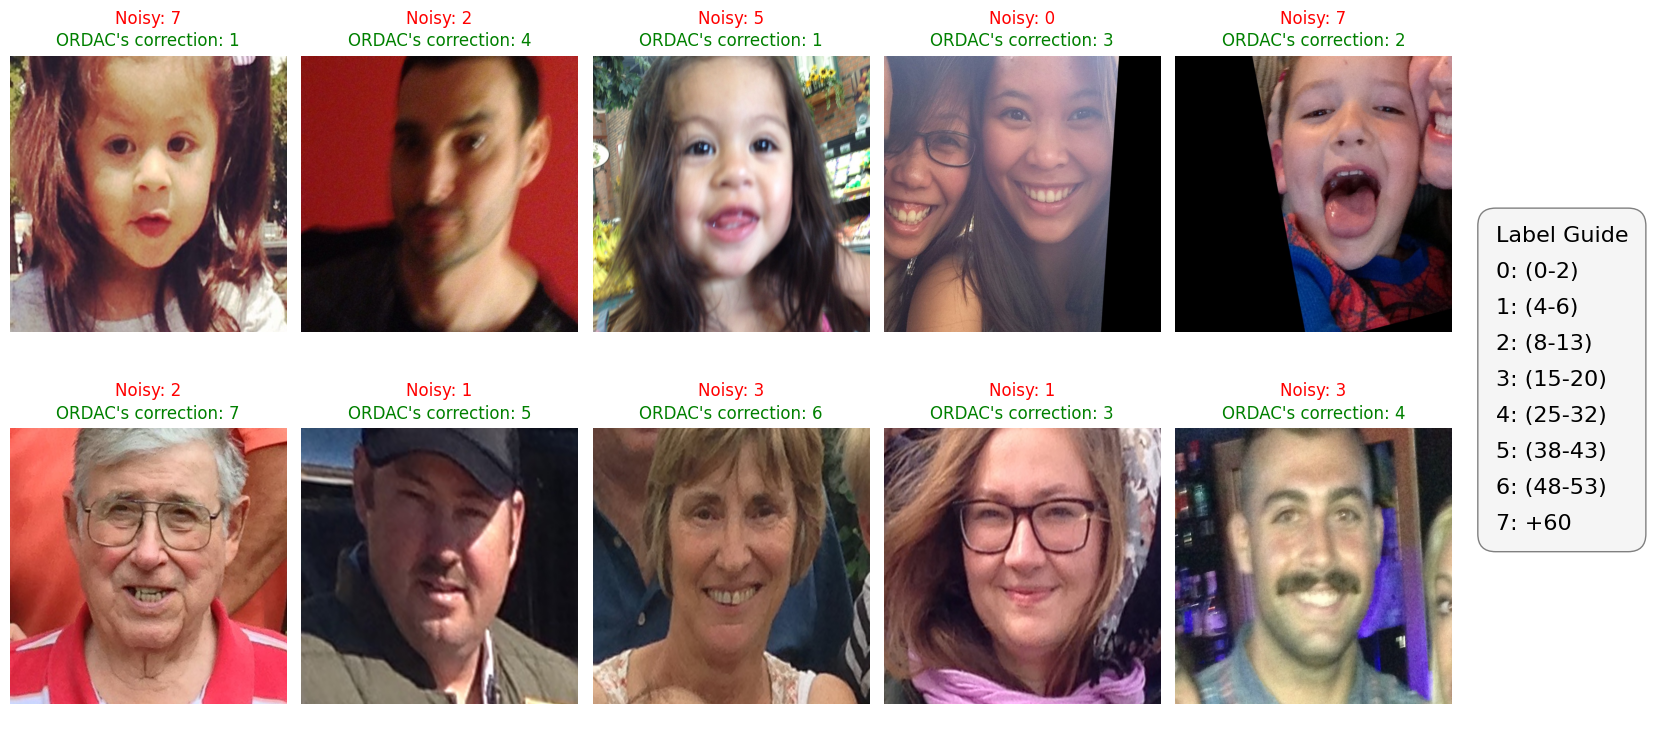

/tmp/ipykernel_2638802/3521887287.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corrupted_df['difference'] = np.abs(corrupted_df['noisy_label'] - corrupted_df['mean'].round().astype(int))
/tmp/ipykernel_2638802/3521887287.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corrupted_df['corrupted'] = corrupted_df['mean'].round().astype(int)


clean_label  corrupted
2            1            552
4            3            548
1            0            498
5            6            483
4            5            429
3            4            356
0            1            283
6            7            208
2            3            190
5            4            131
7            6            104
3            2             98
2            4             83
4            6             81
1            2             74
2            0             71
6            5             69
5            7             54
             3             48
4            2             35
3            5             30
             1             21
4            1             15
6            3             11
1            3              9
6            4              6
7            5              6
4            0              5
2            6              4
5            2              4
2            5              4
1            4              4
0            2   

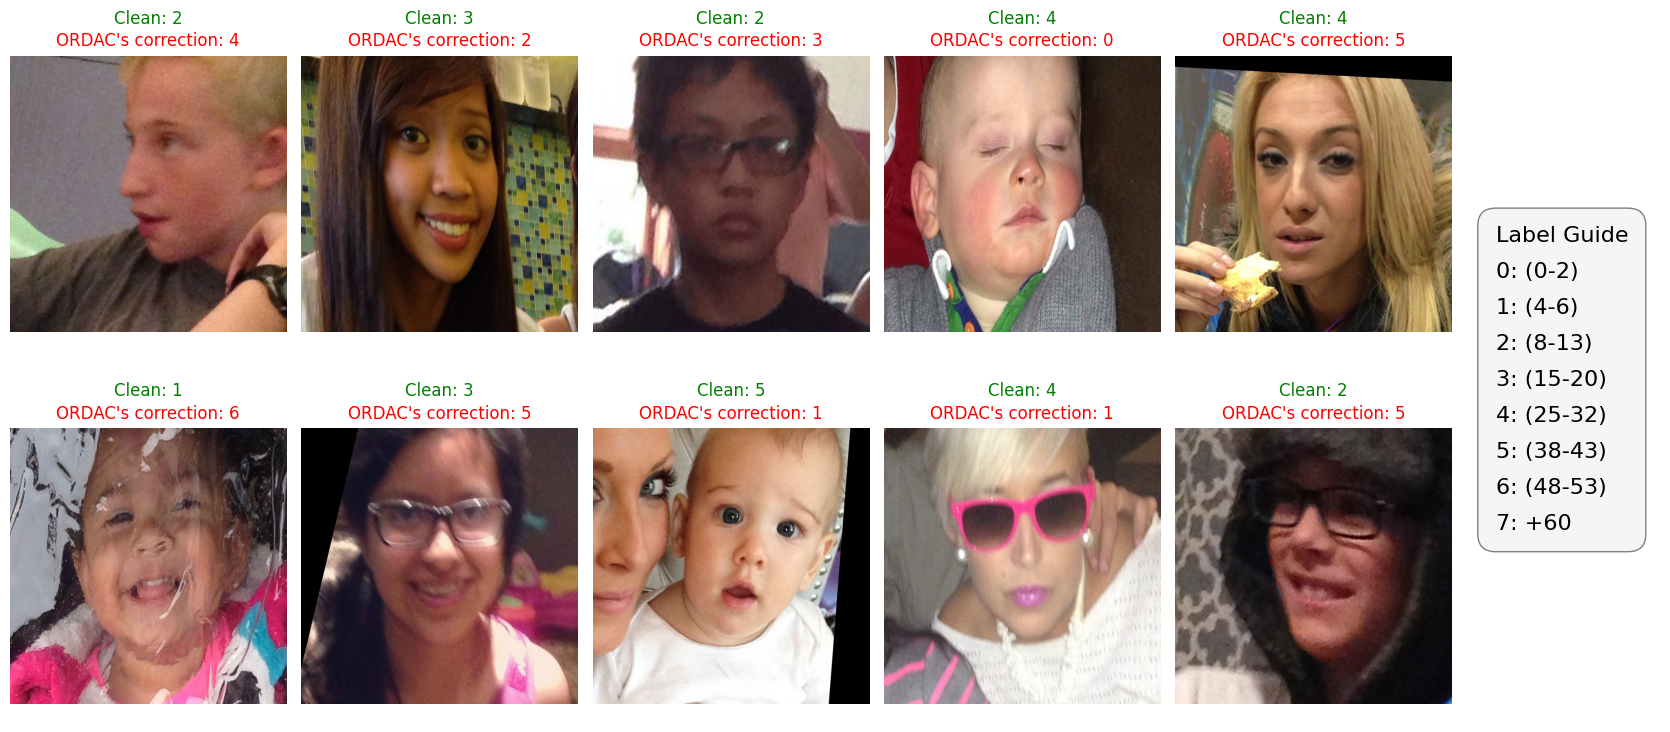

In [43]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_a2_b8',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

plot_configs = [
    (1, 0, 5, 7),
    (1, 1, 4, 5),
    (1, 2, 3, 6),
    (1, 3, 2, 3),
    (1, 4, 1, 4),
    
    (0, 0, 6, 1),
    (0, 1, 2, 4),
    (0, 2, 4, 1),
    (0, 3, 3, 3),
    (0, 4, 5, 2),
]
top_corrections(df, plot_configs)

plot_configs = [
    (1, 0, 5, 1),
    (1, 1, 2, 3),
    (1, 2, 4, 5),
    (1, 3, 3, 4),
    (1, 4, 3, 2),

    (0, 0, 2, 2),
    (0, 1, 1, 3),
    (0, 2, 1, 2),
    (0, 3, 4, 4),
    (0, 4, 1, 4),
]
top_corruptions(df, plot_configs)

/tmp/ipykernel_2638802/3521887287.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corrupted_df['difference'] = np.abs(corrupted_df['noisy_label'] - corrupted_df['mean'].round().astype(int))
/tmp/ipykernel_2638802/3521887287.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corrupted_df['corrupted'] = corrupted_df['mean'].round().astype(int)


clean_label  corrupted
5            4            706
4            5            607
3            4            606
4            3            571
2            3            490
0            1            461
2            1            370
5            6            338
6            7            288
1            0            255
             2            231
7            6            188
3            2            182
2            4            165
6            5            111
4            2             87
5            3             75
4            6             61
5            7             59
6            4             43
3            5             37
7            5             36
1            3             27
0            2             14
4            1             13
1            4              7
2            0              7
6            3              7
5            2              6
0            3              6
3            6              5
             1              5
2            5   

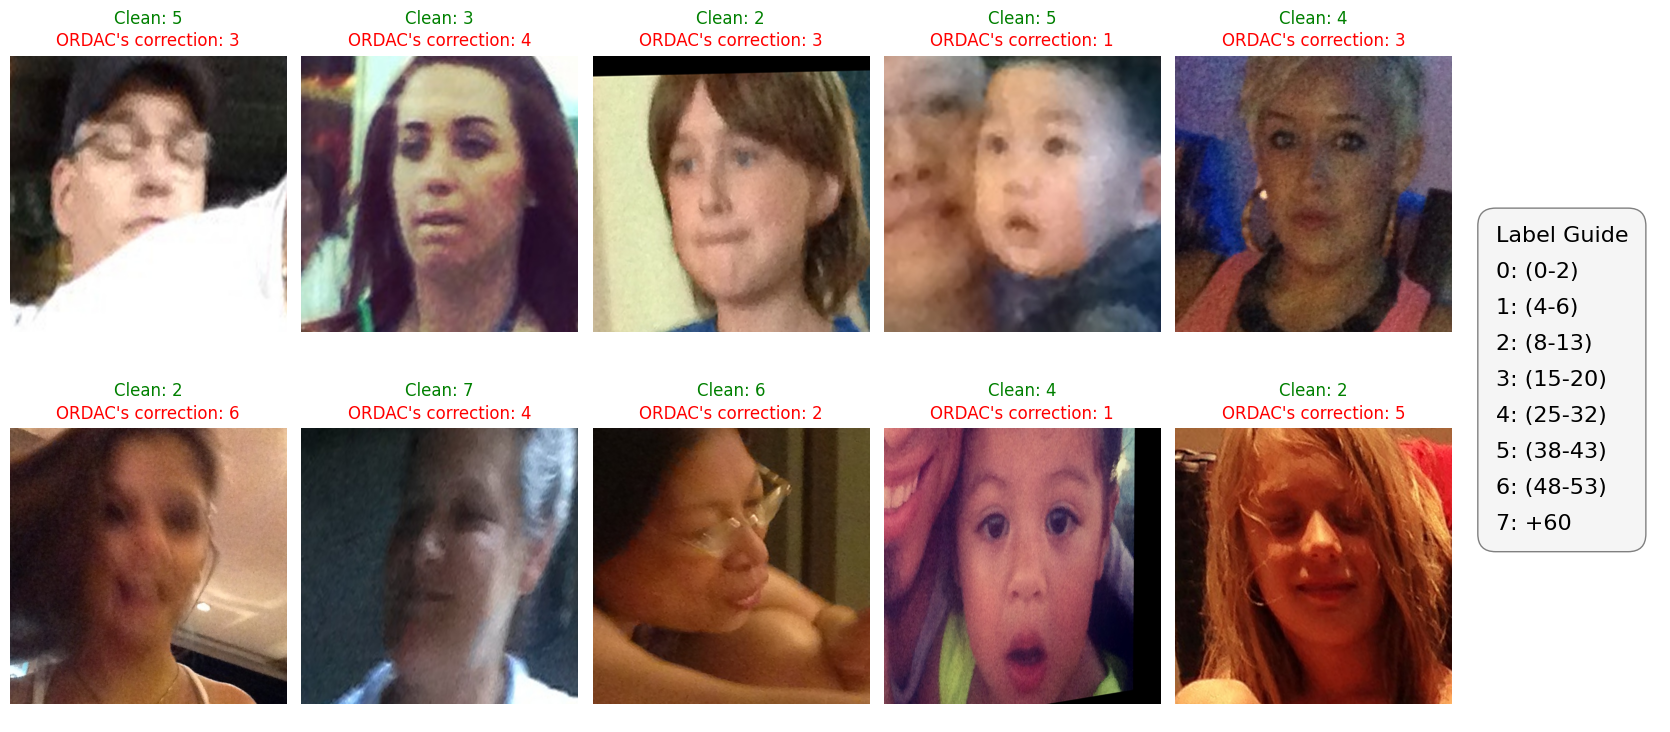

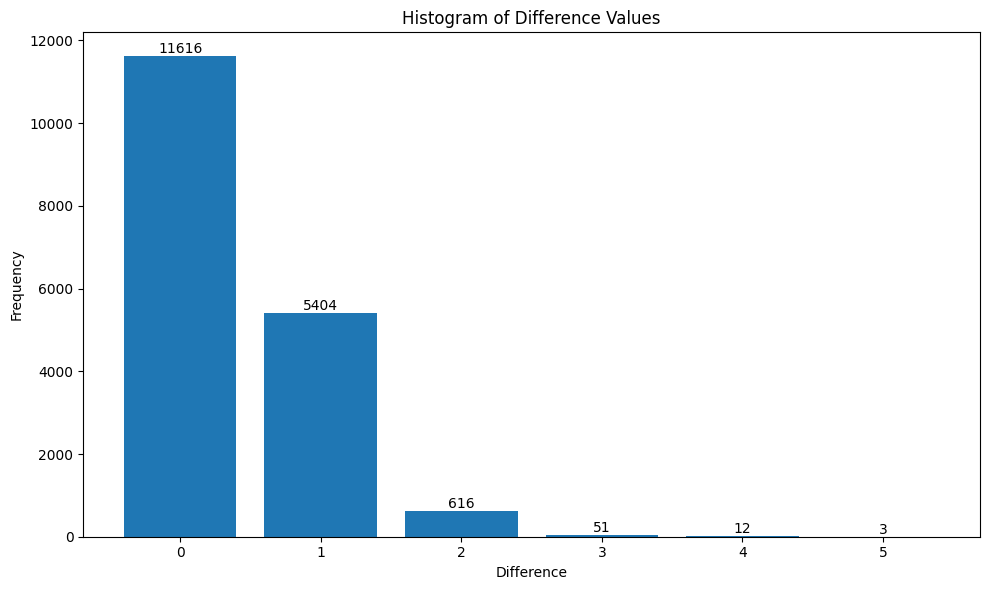

In [58]:
df = get_df(noisy_root='../facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_smcarl_v3',
            clean_root='../facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean')

plot_configs = [
    (1, 0, 4, 2),
    (1, 1, 3, 7),
    (1, 2, 4, 6),
    (1, 3, 3, 4),
    (1, 4, 3, 2),

    (0, 0, 2, 5),
    (0, 1, 1, 3),
    (0, 2, 1, 2),
    (0, 3, 4, 5),
    (0, 4, 1, 4),
]
top_corruptions(df, plot_configs)
correction_hist(df)